In [1]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [2]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [3]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [4]:
VERSION  = "NB_EXP_012"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [5]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [6]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [7]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [8]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(size, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing(p=0.75))
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

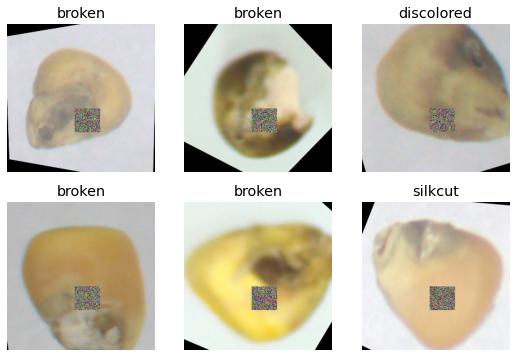

In [9]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [10]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_1k_224.pth


SuggestedLRs(valley=0.0010000000474974513, slide=0.005248074419796467)
CPU: 653/45/3492 MB | GPU: 368/1276/1975 MB | Time 0:00:35.744 | (Consumed/Peaked/Used Total)


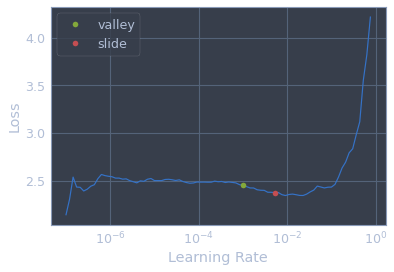

In [11]:
set_seed(42);set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
    dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                           loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy], 
                           splitter=partial(timm_split, cut=-3)).to_fp16()
    
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [12]:
n_epo = 15; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_smooth_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_012_convnext_tiny_256_bs32_epo15_augsV2_mixup_smooth_ft


In [13]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                    loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy], 
                    splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None), MixUp(alpha=0.4)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.365546,0.995791,0.653752,00:33


Better model found at epoch 0 with accuracy value: 0.6537522077560425.


epoch,train_loss,valid_loss,accuracy,time
0,1.098628,0.843661,0.732286,00:44
1,1.039162,0.825987,0.730541,00:44
2,0.992804,0.794850,0.753229,00:44
3,1.002091,0.947421,0.662129,00:44
4,0.960556,0.779241,0.765096,00:44
5,0.960018,0.772432,0.767190,00:44
6,0.926608,0.735478,0.790576,00:44
7,0.910126,0.727561,0.784991,00:44
8,0.892810,0.734833,0.790576,00:44
9,0.886864,0.716984,0.793019,00:44


Better model found at epoch 0 with accuracy value: 0.7322862148284912.
Better model found at epoch 2 with accuracy value: 0.7532286047935486.
Better model found at epoch 4 with accuracy value: 0.7650960087776184.
Better model found at epoch 5 with accuracy value: 0.7671902179718018.
Better model found at epoch 6 with accuracy value: 0.7905759215354919.
Better model found at epoch 9 with accuracy value: 0.79301917552948.
Better model found at epoch 10 with accuracy value: 0.8083769679069519.
Better model found at epoch 12 with accuracy value: 0.8108202219009399.
CPU: 378/81/3816 MB | GPU: 448/2458/2423 MB | Time 0:12:08.206 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.355158,0.979149,0.660384,00:34


Better model found at epoch 0 with accuracy value: 0.660383939743042.


epoch,train_loss,valid_loss,accuracy,time
0,1.121999,0.838126,0.733333,00:44
1,1.036761,0.810435,0.756370,00:44
2,1.012054,0.771617,0.771728,00:44
3,0.990683,0.804402,0.755323,00:45
4,0.969393,0.791707,0.761257,00:44
5,0.946873,0.752078,0.791274,00:44
6,0.948169,0.727808,0.791972,00:44
7,0.920486,0.757955,0.784991,00:44
8,0.917407,0.731773,0.798255,00:44
9,0.899241,0.737223,0.782897,00:44


Better model found at epoch 0 with accuracy value: 0.7333333492279053.
Better model found at epoch 1 with accuracy value: 0.7563700079917908.
Better model found at epoch 2 with accuracy value: 0.7717277407646179.
Better model found at epoch 5 with accuracy value: 0.7912740111351013.
Better model found at epoch 6 with accuracy value: 0.7919721007347107.
Better model found at epoch 8 with accuracy value: 0.7982547879219055.
Better model found at epoch 10 with accuracy value: 0.8104711771011353.
Better model found at epoch 11 with accuracy value: 0.8136125802993774.
CPU: 18/84/3834 MB | GPU: 136/2680/2559 MB | Time 0:12:05.522 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.357896,0.996696,0.659218,00:34


Better model found at epoch 0 with accuracy value: 0.659217894077301.


epoch,train_loss,valid_loss,accuracy,time
0,1.096373,0.838081,0.725559,00:44
1,1.032926,0.816251,0.738128,00:45
2,0.989405,0.808657,0.752095,00:44
3,0.975667,0.835680,0.723464,00:45
4,0.953421,0.788817,0.753492,00:45
5,0.943365,0.794493,0.769204,00:45
6,0.944344,0.782506,0.757332,00:44
7,0.920953,0.751013,0.785265,00:45
8,0.918540,0.724854,0.790852,00:45
9,0.886886,0.741664,0.795391,00:45


Better model found at epoch 0 with accuracy value: 0.7255586385726929.
Better model found at epoch 1 with accuracy value: 0.7381284832954407.
Better model found at epoch 2 with accuracy value: 0.7520949840545654.
Better model found at epoch 4 with accuracy value: 0.7534916400909424.
Better model found at epoch 5 with accuracy value: 0.7692039012908936.
Better model found at epoch 7 with accuracy value: 0.7852653861045837.
Better model found at epoch 8 with accuracy value: 0.7908519506454468.
Better model found at epoch 9 with accuracy value: 0.7953910827636719.
Better model found at epoch 10 with accuracy value: 0.80551677942276.
Better model found at epoch 12 with accuracy value: 0.8090083599090576.
CPU: 42/86/3876 MB | GPU: 44/2628/2603 MB | Time 0:12:07.287 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.370654,0.974958,0.667598,00:34


Better model found at epoch 0 with accuracy value: 0.667597770690918.


epoch,train_loss,valid_loss,accuracy,time
0,1.095396,0.836674,0.738128,00:44
1,1.042620,0.792897,0.757682,00:45
2,0.989631,0.780261,0.771299,00:45
3,0.992269,0.780230,0.759078,00:45
4,0.958098,0.755584,0.778631,00:45
5,0.961132,0.778794,0.762919,00:45
6,0.955397,0.725970,0.799232,00:45
7,0.934425,0.707651,0.804469,00:45
8,0.904509,0.704120,0.803771,00:45
9,0.897484,0.690199,0.808310,00:45


Better model found at epoch 0 with accuracy value: 0.7381284832954407.
Better model found at epoch 1 with accuracy value: 0.7576815485954285.
Better model found at epoch 2 with accuracy value: 0.771298885345459.
Better model found at epoch 4 with accuracy value: 0.7786312699317932.
Better model found at epoch 6 with accuracy value: 0.7992318272590637.
Better model found at epoch 7 with accuracy value: 0.8044692873954773.
Better model found at epoch 9 with accuracy value: 0.8083100318908691.
Better model found at epoch 11 with accuracy value: 0.811103343963623.
Better model found at epoch 12 with accuracy value: 0.8170391321182251.
Better model found at epoch 14 with accuracy value: 0.8198323845863342.
CPU: -28/26/3848 MB | GPU: 80/2564/2683 MB | Time 0:12:09.794 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.338844,0.971746,0.663757,00:34


Better model found at epoch 0 with accuracy value: 0.6637569665908813.


epoch,train_loss,valid_loss,accuracy,time
0,1.103845,0.829458,0.740223,00:45
1,1.029164,0.810534,0.751047,00:45
2,1.000611,0.775525,0.773045,00:45
3,0.980288,0.779543,0.768156,00:45
4,0.983020,0.738664,0.788757,00:45
5,0.955796,0.758296,0.783869,00:45
6,0.945255,0.717251,0.789804,00:45
7,0.932808,0.725829,0.800628,00:45
8,0.920066,0.709927,0.806215,00:45
9,0.894736,0.719822,0.803771,00:45


Better model found at epoch 0 with accuracy value: 0.7402234673500061.
Better model found at epoch 1 with accuracy value: 0.7510474920272827.
Better model found at epoch 2 with accuracy value: 0.7730447053909302.
Better model found at epoch 4 with accuracy value: 0.7887569665908813.
Better model found at epoch 6 with accuracy value: 0.7898044586181641.
Better model found at epoch 7 with accuracy value: 0.8006284832954407.
Better model found at epoch 8 with accuracy value: 0.8062151074409485.
Better model found at epoch 10 with accuracy value: 0.8076117038726807.
Better model found at epoch 12 with accuracy value: 0.811103343963623.
Better model found at epoch 13 with accuracy value: 0.8159916400909424.
CPU: 28/83/3876 MB | GPU: 112/2426/2795 MB | Time 0:12:09.580 | (Consumed/Peaked/Used Total)


In [14]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80768, 0.81361, 0.81494, 0.81983, 0.81599]
Avg: 0.81441
Std: 0.00395
